In [1]:
import gym
from gym import spaces
import numpy as np
import tkinter as tk
from PIL import Image, ImageTk
import time
import matplotlib.pyplot as plt

Episode 0: Reward: -102.52, Path Length: 1146
Episode 50: Reward: -0.5300000000000002, Path Length: 55
Episode 100: Reward: -3.369999999999999, Path Length: 42
Episode 150: Reward: -0.14000000000000012, Path Length: 16
Episode 200: Reward: -0.09000000000000008, Path Length: 11
Episode 250: Reward: -3.1100000000000003, Path Length: 16
Episode 300: Reward: -0.18000000000000016, Path Length: 20
Episode 350: Reward: 0.87, Path Length: 14
Episode 400: Reward: 0.9, Path Length: 11
Episode 450: Reward: 0.9, Path Length: 11
Episode 500: Reward: 0.9, Path Length: 11
Episode 550: Reward: 0.9, Path Length: 11
Episode 600: Reward: 0.9, Path Length: 11
Episode 650: Reward: -0.1100000000000001, Path Length: 13
Episode 700: Reward: 0.9, Path Length: 11
Episode 750: Reward: 0.9, Path Length: 11
Episode 800: Reward: 0.9, Path Length: 11
Episode 850: Reward: 0.9, Path Length: 11
Episode 900: Reward: 0.9, Path Length: 11
Episode 950: Reward: 0.9, Path Length: 11


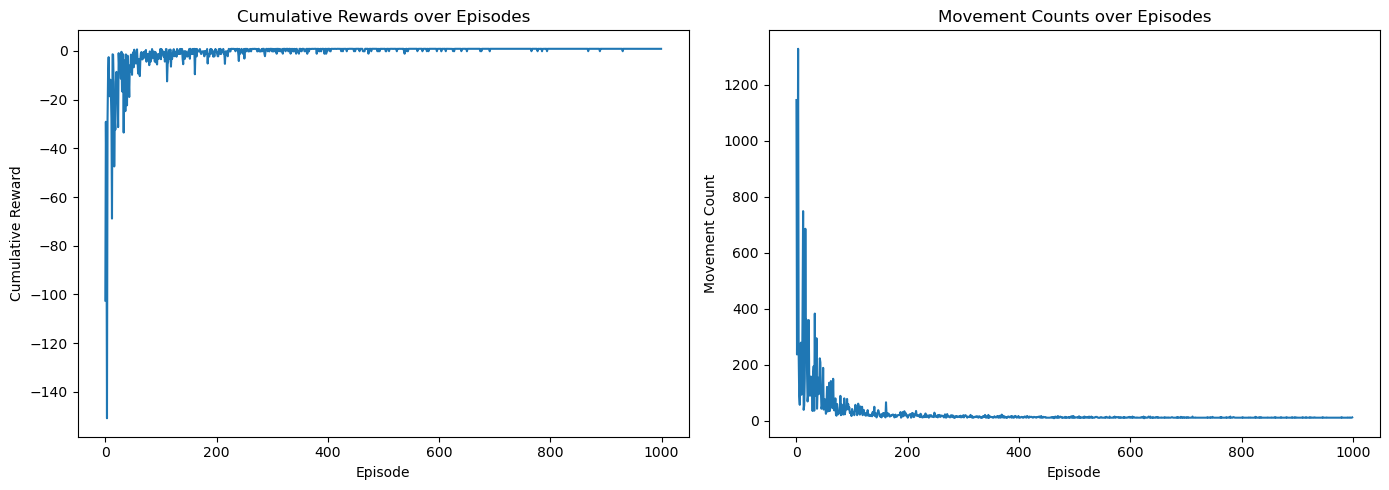

In [5]:
class GridWorldEnv(gym.Env):
    def __init__(self, grid_size=10):
        super(GridWorldEnv, self).__init__()
        self.grid_size = grid_size
        self.state = (0, 0)  # Cat starts from (0, 0)
        self.goal_state = (grid_size - 1, grid_size - 1)
        self.obstacles = [(2, 2), (2, 3), (1, 2), (2, 1), (5, 4), (5, 6), (3, 6), (2, 7)]  # More obstacles added
        
        self.action_space = spaces.Discrete(8)
        self.observation_space = spaces.Tuple((spaces.Discrete(grid_size), spaces.Discrete(grid_size)))
        
        self.actions = ['up', 'down', 'left', 'right', 'up_left', 'up_right', 'down_left', 'down_right']
    
    def reset(self):
        self.state = (0, 0)
        return self.state
    
    def step(self, action):
        x, y = self.state
        if action == 0 and x > 0:  # Up
            x -= 1
        elif action == 1 and x < self.grid_size - 1:  # Down
            x += 1
        elif action == 2 and y > 0:  # Left
            y -= 1
        elif action == 3 and y < self.grid_size - 1:  # Right
            y += 1
        elif action == 4 and x > 0 and y > 0:  # Up-Left
            x -= 1
            y -= 1
        elif action == 5 and x > 0 and y < self.grid_size - 1:  # Up-Right
            x -= 1
            y += 1
        elif action == 6 and x < self.grid_size - 1 and y > 0:  # Down-Left
            x += 1
            y -= 1
        elif action == 7 and x < self.grid_size - 1 and y < self.grid_size - 1:  # Down-Right
            x += 1
            y += 1
        
        self.state = (x, y)
        
        if self.state in self.obstacles:
            reward = -1
        elif self.state == self.goal_state:
            reward = 1
        else:
            reward = -0.01  # Smaller penalty for each step to encourage more exploration
        
        done = self.state == self.goal_state
        return self.state, reward, done, {}
    
    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        x, y = self.state
        gx, gy = self.goal_state
        grid[x, y] = -1
        grid[gx, gy] = 1
        for ox, oy in self.obstacles:
            grid[ox, oy] = -2
        return grid

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((env.grid_size, env.grid_size, env.action_space.n))
        
        self.episode_cumulative_rewards = []  # Track cumulative rewards per episode
        self.all_episode_paths = []  # Track all paths taken in each episode
        self.episode_movement_counts = []  # Track movement count per episode
        
        self.total_cumulative_reward = 0  # Total cumulative reward across all episodes
        self.total_movements = 0  # Total movements across all episodes

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            x, y = state
            return np.argmax(self.q_table[x, y])

    def update_q_table(self, state, action, reward, next_state):
        x, y = state
        next_x, next_y = next_state
        best_next_action = np.argmax(self.q_table[next_x, next_y])
        td_target = reward + self.gamma * self.q_table[next_x, next_y, best_next_action]
        td_error = td_target - self.q_table[x, y, action]
        self.q_table[x, y, action] += self.alpha * td_error

    def train(self, num_episodes=1000):
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            episode_rewards = []
            episode_path = [state]  # Track the path taken in this episode
            movement_count = 0  # Track number of movements in this episode
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update_q_table(state, action, reward, next_state)
                state = next_state
                episode_rewards.append(reward)
                episode_path.append(state)
                movement_count += 1
                if done:
                    break
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
            self.episode_cumulative_rewards.append(np.sum(episode_rewards))
            self.all_episode_paths.append(episode_path)
            self.episode_movement_counts.append(movement_count)
            
            self.total_cumulative_reward += np.sum(episode_rewards)
            self.total_movements += movement_count
            
            if episode % 50 == 0:
                print(f"Episode {episode}: Reward: {np.sum(episode_rewards)}, Path Length: {movement_count}")
    
    def plot_training(self):
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.episode_cumulative_rewards)
        plt.title("Cumulative Rewards over Episodes")
        plt.xlabel("Episode")
        plt.ylabel("Cumulative Reward")
        
        plt.subplot(1, 2, 2)
        plt.plot(self.episode_movement_counts)
        plt.title("Movement Counts over Episodes")
        plt.xlabel("Episode")
        plt.ylabel("Movement Count")
        
        plt.tight_layout()
        plt.show()


# Visualizer with reward and movement count display
class RLVisualizer(tk.Tk):
    def __init__(self, agent, env):
        super().__init__()
        self.agent = agent
        self.env = env
        self.grid_size = env.grid_size
        self.cell_size = 40  # Decreased cell size
        
        self.attributes('-fullscreen', True)  # Fullscreen mode
        
        self.bind("<Escape>", self.exit_fullscreen)  # Bind Escape key to exit fullscreen
        
        screen_width = self.winfo_screenwidth()
        screen_height = self.winfo_screenheight()
        
        # Calculate the position to center the canvas
        self.canvas_width = self.grid_size * self.cell_size
        self.canvas_height = self.grid_size * self.cell_size
        x_offset = (screen_width - self.canvas_width) // 2
        y_offset = (screen_height - self.canvas_height) // 2
        
        self.canvas = tk.Canvas(self, width=self.canvas_width, height=self.canvas_height)
        self.canvas.place(x=x_offset, y=y_offset)  # Center the canvas
        
        # Create labels for displaying reward and movement count
        self.reward_label = tk.Label(self, text="Cumulative Reward: 0", font=("Arial", 16))
        self.reward_label.pack(side=tk.TOP, pady=20)
        
        self.move_count_label = tk.Label(self, text="Movement Count: 0", font=("Arial", 16))
        self.move_count_label.pack(side=tk.TOP, pady=20)
        
        # Load images and store them as instance variables to prevent garbage collection
        self.cat_img = ImageTk.PhotoImage(Image.open("cat.webp").resize((self.cell_size, self.cell_size)))
        self.mouse_img = ImageTk.PhotoImage(Image.open("mouse.jfif").resize((self.cell_size, self.cell_size)))
        self.obstacle_img = ImageTk.PhotoImage(Image.open("obstacle.jfif").resize((self.cell_size, self.cell_size)))
        
        # Create a list to hold references to the images
        self.image_refs = [self.cat_img, self.mouse_img, self.obstacle_img]
        
        self.after(100, self.render_grid)  # Delay rendering to ensure images are loaded
        self.after(0, self.update_grid)
    
    def exit_fullscreen(self, event=None):
        self.attributes('-fullscreen', False)
        self.geometry(f"{self.canvas_width}x{self.canvas_height}+{(self.winfo_screenwidth()-self.canvas_width)//2}+{(self.winfo_screenheight()-self.canvas_height)//2}")
    
    def render_grid(self):
        self.canvas.delete("all")
        grid = self.env.render()
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                x0, y0 = j * self.cell_size, i * self.cell_size
                x1, y1 = x0 + self.cell_size, y0 + self.cell_size
                if grid[i, j] == -1:
                    self.canvas.create_image(x0, y0, anchor="nw", image=self.cat_img)
                elif grid[i, j] == 1:
                    self.canvas.create_image(x0, y0, anchor="nw", image=self.mouse_img)
                elif grid[i, j] == -2:
                    self.canvas.create_image(x0, y0, anchor="nw", image=self.obstacle_img)
                else:
                    self.canvas.create_rectangle(x0, y0, x1, y1, outline="black", fill="lightblue")
    
    def update_grid(self):
        state = self.env.reset()
        done = False
        while not done:
            self.render_grid()
            self.update_idletasks()
            self.update()
            time.sleep(0.5)
            action = self.agent.choose_action(state)
            state, _, done, _ = self.env.step(action)
            # Update reward label
            self.reward_label.config(text=f"Cumulative Reward: {self.agent.total_cumulative_reward:.2f}")
            # Update movement count label
            self.move_count_label.config(text=f"Movement Count: {self.agent.total_movements}")
        
        self.render_grid()

# Main execution
if __name__ == "__main__":
    env = GridWorldEnv(grid_size=10)
    agent = QLearningAgent(env)
    agent.train(num_episodes=1000)
    agent.plot_training()  # Visualize the training process
    
    app = RLVisualizer(agent, env)
    app.mainloop()
